# Evaluation Metrics for Classification

* Use the same data as in the previous session: Churn Prediction (Identify clients that want to leave the company)
* Data https://www.kaggle.com/blastchar/telco-customer-churn

## Review of previous Session

* Metrics: A function, that compares the actual values with the predicted values. It outputs a single umber that measures the goodness of the model

### Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

### Load Data

In [2]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

### Data Preparation

In [3]:
# Unify column names
df.columns = df.columns.str.lower().str.replace(" ", "_")
# List of all categorical columns
categorical_columns = list(df.dtypes[df.dtypes == object].index)
# Unify categolrical columns
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

# Change "totalcharges to numeric and fill na with 0
df.totalcharges = pd.to_numeric(df["totalcharges"], errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

# Change "churn" to type int
df["churn"] = (df["churn"] == "yes").astype(int)

### Model Setup

In [4]:
# 80% train + val = train_full, 20% test
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
# 75% train, 25% val out of train_full 
# 60% train, 20% val, 20% test out of df
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["churn"]
y_val = df_val["churn"]
y_test = df_test["churn"]

# delete "churn from df_train, df_val, df_test (not from df)
del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [5]:
numerical = ["tenure", "monthlycharges", "totalcharges"]
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [6]:
# First convert to dictionary
train_dicts = df_train[categorical+numerical].to_dict(orient="records")

dv = DictVectorizer(sparse=False) # don't use sparse matrix
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/jens/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Predictions

In [7]:
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred > 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and Dummy Model

* Evaluate the model on different thresholds
* Check the accuracy of the dummy baseline

In [8]:
# How many validation values do we have?
len(y_val)

1409

In [9]:
# How many correct decisions did we take?
(y_val == churn_decision).sum()

1132

* Accruracy: Correct Prediction / All Predictions

In [10]:
1132/1409

0.8034066713981547

* Is the threshold of 0.5 good?
* Test the model with different thresholds

In [11]:
thresholds = np.linspace(0,1,21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:
scores = []
for t in thresholds:
    churn_decision = (y_pred > t)
    score = (y_val == churn_decision).mean()
    print(f"threshold: {t:.2f}, score: {score:.3f}")
    scores.append(score)

threshold: 0.00, score: 0.274
threshold: 0.05, score: 0.510
threshold: 0.10, score: 0.591
threshold: 0.15, score: 0.666
threshold: 0.20, score: 0.710
threshold: 0.25, score: 0.739
threshold: 0.30, score: 0.760
threshold: 0.35, score: 0.772
threshold: 0.40, score: 0.785
threshold: 0.45, score: 0.794
threshold: 0.50, score: 0.803
threshold: 0.55, score: 0.801
threshold: 0.60, score: 0.796
threshold: 0.65, score: 0.786
threshold: 0.70, score: 0.766
threshold: 0.75, score: 0.744
threshold: 0.80, score: 0.734
threshold: 0.85, score: 0.726
threshold: 0.90, score: 0.726
threshold: 0.95, score: 0.726
threshold: 1.00, score: 0.726


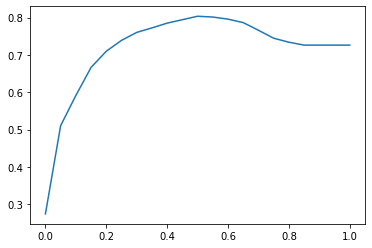

In [13]:
plt.plot(thresholds, scores);

* Here 0.5 is the best threshold, before and afterwards the accuracy is lower
* Scikit-learn provides a function for the accuracy (above we wrote our own function)

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, (y_pred > 0.5))

0.8034066713981547

* Special cases: threshold = 0 and threshold = 1
* threshold = 1 means, we are predicting that no customer is churning
    * For this case (Dummy Model) the accuracy is ~73%
* threshold = 0 means, we are predicting that all customers are churning
* Our model gives an accuracy of 0.8

In [16]:
# non-churning users
1 - y_val.mean()

0.7260468417317246

* In this data set that are much more non-churning than churning users
* We have class imbalance in this data set
    * For class imbalance, predicting the majority class already gives quite good accuracy and accuracy can be a misleading metric

## Confusion Table

* Different types of errors and correct decisions
* Arranging them in a table

![confusion_table](Screenshot1.png "Confusion Table")
![confusion_table](Screenshot2.png "Confusion Table")

In [17]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
tp = (predict_positive & actual_positive).sum()
tp

210

In [19]:
tn = (predict_negative & actual_negative).sum()
tn

922

In [20]:
fp = (predict_positive & actual_negative).sum()
fp

101

In [21]:
fn = (predict_negative & actual_positive).sum()
fn

176

In [22]:
confusion_matrix = np.array([
                        [tn, fp],
                        [fn, tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

* We have a lot of more false negatives than false positives
    * False positives are predicted to churn, but they are not going to. We would send them a discount e-mail, though not necessary and would loose profit
    * False positives are not receiving an e-mail and are leaving, also loosing profit in this case

In [23]:
# in relative numbers
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

![confusion_table](Screenshot3.png "Confusion Table")

## Precission and Recall

* Very useful for binary clasification problems

In [24]:
# Accuracy
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

Now we will look at other metrics:
* **Precision: Fraction of positive predictions that are correct**
    * tp / (tp + fp)

In [25]:
p = tp / (tp + fp)
p

0.6752411575562701

* This means that (1-p)~33% will get a promotional e-mail, although they are not going to churn 

* **Recall: Fraction of correctly identified positive examples**
    * tp / (tp + fn) = tp / (#positive observations)

In [26]:
r = tp / (tp + fn)
r

0.5440414507772021

* This means that we failed to identify (1-r)~46% of people who are churning 

## ROC Curves

### TPR and FPR

* TPR: True positive rate TP / (FN + TP) (Nr of true positives by all positives) == RECALL
* FPR: False positive rate FP / (TN + FP) (Nr of false positives by all negatives)

![confusion_table](Screenshot4.png "Confusion Table")

In [29]:
tpr = tp / (fn + tp)
tpr

0.5440414507772021

In [28]:
fpr = fp / (tn + fp)
fpr

0.09872922776148582

* We now calculated these numbers for the threshold 0.5
* ROC curves compares results different thresholds

In [39]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [40]:
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 914, 1, 109),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 683, 7, 340),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 640, 14, 383),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 329, 341, 57, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 304, 70, 719),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 296, 256, 90, 767),
 (0.29, 291, 245, 95, 778),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 213, 112, 810),
 (0.35000000000000003, 272,

In [42]:
# put scores into data frame
columns =["threshold", "tp", "fp", "fn", "tn"]

df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,914,1,109
2,0.02,384,830,2,193
3,0.03,383,766,3,257
4,0.04,381,715,5,308


In [45]:
df_scores["tpr"] = df_scores.tp/(df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp/(df_scores.fp + df_scores.tn)

In [47]:
df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,914,1,109,0.997409,0.893451
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925


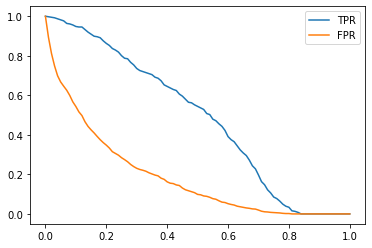

In [53]:
plt.plot(df_scores["threshold"], df_scores["tpr"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["fpr"], label="FPR")
plt.legend();

* threshold=0 is the dumy model, that predicts everyone is churning. In this case bose TPR and FPR are 1.
* We want to minimize FPR and maximiz TPR

### Random Model

In [55]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [57]:
# Accuracy of random model
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [58]:
# write tpr, fpr into dtaframe
# as previous code, but in a function
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))
        
    columns =["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)
        
    df_scores["tpr"] = df_scores.tp/(df_scores.tp + df_scores.fn)
    df_scores["fpr"] = df_scores.fp/(df_scores.fp + df_scores.tn)
    
    return df_scores

In [59]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

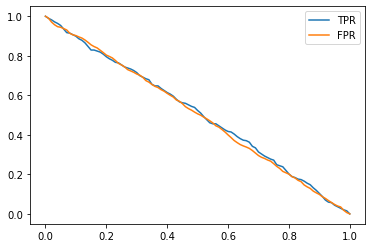

In [60]:
plt.plot(df_rand["threshold"], df_rand["tpr"], label="TPR")
plt.plot(df_rand["threshold"], df_rand["fpr"], label="FPR")
plt.legend();

### Ideal Model
* All predictions are correct

In [61]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [63]:
# create ideal validation set
y_ideal = np.repeat([0,1],[num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [64]:
# create predictions (numbers between 0 and 1)
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [67]:
# accuracy of ideal model
# 72.6 of the customers are not churning
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [68]:
df_ideal =  tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [69]:
df_ideal.head()

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.0,1.000000
1,0.01,386,1008,0,15,1.0,0.985337
2,0.02,386,994,0,29,1.0,0.971652
3,0.03,386,980,0,43,1.0,0.957967
4,0.04,386,966,0,57,1.0,0.944282


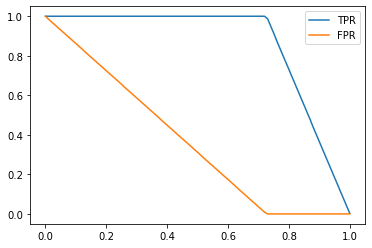

In [72]:
plt.plot(df_ideal["threshold"], df_ideal["tpr"], label="TPR")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], label="FPR")
plt.legend();

* cut at threshold 0.726
* TPR is maximized and FPR is minimized for this threshold
* Such an ideal moel does not exist in reality, but it helps us to see how good our model is

### Putting everything together

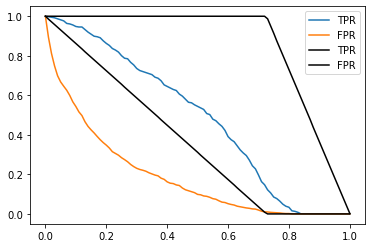

In [73]:
plt.plot(df_scores["threshold"], df_scores["tpr"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["fpr"], label="FPR")

#plt.plot(df_rand["threshold"], df_rand["tpr"], label="TPR")
#plt.plot(df_rand["threshold"], df_rand["fpr"], label="FPR")

plt.plot(df_ideal["threshold"], df_ideal["tpr"], label="TPR", color="black")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], label="FPR", color="black")
plt.legend();

* Comparing two models is not always intuative
* These two models have different thresholds
    * Compare TPR and FPR

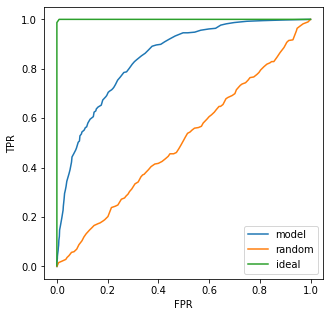

In [79]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot(df_rand.fpr, df_rand.tpr, label="random")
plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();

* We want to get as close to the ideal model
* To see how goo a model is we can draw the following plot:

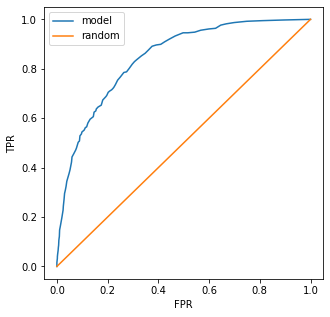

In [82]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot([0, 1], [0,1], label="random")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();

* We can uses sklearn to plot the ROC curve

In [83]:
from sklearn.metrics import roc_curve

In [84]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

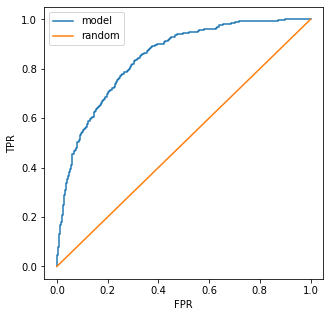

In [85]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label="model")
plt.plot([0, 1], [0,1], label="random")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();

## ROC AUC

* Area under the ROC curve - useful metric for binary classification
* Getting the average prediction and the spread within predictions

### Cross Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

### Summary

* Metric: A single number that describes the performance of a model
* Accuracy: fraction of correct answers; sometimes misleading
* Precision and Recall are less misleading when we have class imbalance
* ROC curve: A way to evaluate the performance at all thresholds; ok to use with class imbalance
* K-fold Cross Validation: more reliable estimate for performance (mean + std)